In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import time


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from darts import TimeSeries
from darts.models import ARIMA, NBEATSModel
from darts.metrics import mae, mape


from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (20, 8)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.random.seed(42)
torch.manual_seed(42)

torch.set_float32_matmul_precision('high')

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


In [13]:
DB_PATH = "../data/weather.db"
TABLE_NAME = "weather_data"

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", conn, parse_dates=['date'], index_col='date')
conn.close()
df.sort_index(inplace=True)

print(f"Загружено {len(df)} записей.")
print("Структура данных:")
df.info()

Загружено 5448 записей.
Структура данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5448 entries, 2010-11-01 to 2025-09-30
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cloud_cover_percent_day      5448 non-null   float64
 1   cloud_cover_percent_evening  5448 non-null   float64
 2   cloud_cover_percent_morning  5448 non-null   float64
 3   pressure_day                 5448 non-null   float64
 4   pressure_evening             5448 non-null   float64
 5   pressure_morning             5448 non-null   float64
 6   temperature_day              5448 non-null   float64
 7   temperature_evening          5448 non-null   float64
 8   temperature_morning          5448 non-null   float64
 9   wind_direction_deg_day       5448 non-null   float64
 10  wind_direction_deg_evening   5448 non-null   float64
 11  wind_direction_deg_morning   5448 non-null   float64
 12  wind_speed_day  

In [ ]:
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month


days_in_year = (df.index.is_leap_year).astype(int) + 365
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / days_in_year)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / days_in_year)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

for period in ['morning', 'day', 'evening']:
    col_name = f'wind_direction_deg_{period}'
    df[f'{col_name}_sin'] = np.sin(np.deg2rad(df[col_name]))
    df[f'{col_name}_cos'] = np.cos(np.deg2rad(df[col_name]))

features_for_lags = [
    'temperature_day', 'pressure_day', 'cloud_cover_percent_day', 'wind_speed_day'
]
for col in features_for_lags:
    for lag in [1, 2, 7]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

cols_to_drop = [
    'day_of_year', 'month',
    'wind_direction_deg_morning', 'wind_direction_deg_day', 'wind_direction_deg_evening'
]
df = df.drop(columns=cols_to_drop)
df = df.dropna()

print("\nДатафрейм после Feature Engineering:")
df.info()
display(df.head())


Датафрейм после Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5441 entries, 2010-11-08 to 2025-09-30
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cloud_cover_percent_day         5441 non-null   float64
 1   cloud_cover_percent_evening     5441 non-null   float64
 2   cloud_cover_percent_morning     5441 non-null   float64
 3   pressure_day                    5441 non-null   float64
 4   pressure_evening                5441 non-null   float64
 5   pressure_morning                5441 non-null   float64
 6   temperature_day                 5441 non-null   float64
 7   temperature_evening             5441 non-null   float64
 8   temperature_morning             5441 non-null   float64
 9   wind_speed_day                  5441 non-null   float64
 10  wind_speed_evening              5441 non-null   float64
 11  wind_speed_morning              5441 no

,cloud_cover_percent_day,cloud_cover_percent_evening,cloud_cover_percent_morning,pressure_day,pressure_evening,pressure_morning,temperature_day,temperature_evening,temperature_morning,wind_speed_day,...,temperature_day_lag_7,pressure_day_lag_1,pressure_day_lag_2,pressure_day_lag_7,cloud_cover_percent_day_lag_1,cloud_cover_percent_day_lag_2,cloud_cover_percent_day_lag_7,wind_speed_day_lag_1,wind_speed_day_lag_2,wind_speed_day_lag_7
date,,,,,,,,,,,,,,,,,,,,,
2010-11-08,58.500,8.500,56.500,741.500,747.000,737.500,-0.200,-2.500,-4.100,7.000,...,2.300,730.000,725.000,750.000,92.500,55.000,45.000,4.500,2.500,2.000
2010-11-09,95.000,100.000,80.000,749.500,747.500,750.500,2.000,3.000,-1.750,3.500,...,-1.050,741.500,730.000,743.500,58.500,92.500,80.000,7.000,4.500,3.000
2010-11-10,87.500,80.000,90.000,749.500,750.000,747.500,6.150,5.200,4.100,1.000,...,2.500,749.500,741.500,743.500,95.000,58.500,88.500,3.500,7.000,4.000
2010-11-11,91.000,81.500,80.000,746.000,744.000,747.500,8.350,6.650,5.100,1.500,...,4.000,749.500,749.500,744.000,87.500,95.000,100.000,1.000,3.500,4.500
2010-11-12,80.000,95.000,80.000,738.000,739.000,738.500,5.350,5.550,6.450,5.000,...,6.650,746.000,749.500,729.500,91.000,87.500,89.000,1.500,1.000,4.000


In [ ]:
TARGET_COLS = ['temperature_morning', 'temperature_day', 'temperature_evening']
FEATURE_COLS = [col for col in df.columns if not col.startswith('temperature_')]

print(f"Количество признаков (features): {len(FEATURE_COLS)}")
print(f"Целевые переменные (targets): {TARGET_COLS}")

test_cutoff = df.index.max() - pd.DateOffset(years=1)
val_cutoff = test_cutoff - pd.DateOffset(years=1)

df_train = df[df.index < val_cutoff]
df_val = df[(df.index >= val_cutoff) & (df.index < test_cutoff)]
df_test = df[df.index >= test_cutoff]

print(f"\nРазмер Train: {len(df_train)}")
print(f"Размер Validation: {len(df_val)}")
print(f"Размер Test: {len(df_test)}")

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(df_train[FEATURE_COLS])
y_train_scaled = target_scaler.fit_transform(df_train[TARGET_COLS])

X_val_scaled = feature_scaler.transform(df_val[FEATURE_COLS])
y_val_scaled = target_scaler.transform(df_val[TARGET_COLS])
X_test_scaled = feature_scaler.transform(df_test[FEATURE_COLS])
y_test_scaled = target_scaler.transform(df_test[TARGET_COLS])

Количество признаков (features): 28
Целевые переменные (targets): ['temperature_morning', 'temperature_day', 'temperature_evening']

Размер Train: 4709
Размер Validation: 366
Размер Test: 366


In [ ]:
ts_target_train = TimeSeries.from_values(y_train_scaled)
ts_target_val = TimeSeries.from_values(y_val_scaled)
ts_target_test = TimeSeries.from_values(y_test_scaled)

In [ ]:
print("--- Обучение ARIMA ---")
start_time = time.time()

full_target_ts = TimeSeries.from_dataframe(df, value_cols=TARGET_COLS)
train_arima_ts, val_test_arima_ts = full_target_ts.split_before(pd.Timestamp(val_cutoff))
_, test_arima_ts = val_test_arima_ts.split_before(pd.Timestamp(test_cutoff))

arima_preds_list = []
for target_name in TARGET_COLS:
    print(f"Обучаем ARIMA для '{target_name}'...")
    model_arima = ARIMA(p=5, d=1, q=1)
    model_arima.fit(train_arima_ts[target_name])
    preds = model_arima.predict(len(val_test_arima_ts))
    
    arima_preds_list.append(preds[len(df_val):].values())

arima_preds = np.hstack(arima_preds_list)
arima_time = time.time() - start_time
print(f"ARIMA | Время: {arima_time:.2f} сек.")

--- Обучение ARIMA ---
Обучаем ARIMA для 'temperature_morning'...
Обучаем ARIMA для 'temperature_day'...
Обучаем ARIMA для 'temperature_evening'...
ARIMA | Время: 2.82 сек.


In [18]:
print("\n--- Обучение N-BEATS ---")
start_time = time.time()

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=len(TARGET_COLS),
    n_epochs=50,
    random_state=42,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=3,
    num_layers=4,
    layer_widths=256,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu", "devices": 1}
)

model_nbeats.fit(series=ts_target_train, val_series=ts_target_val, verbose=False)
preds_nbeats_scaled = model_nbeats.predict(len(ts_target_test))

nbeats_preds = target_scaler.inverse_transform(preds_nbeats_scaled.values())
nbeats_time = time.time() - start_time
print(f"N-BEATS | Время: {nbeats_time:.2f} сек.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Обучение N-BEATS ---


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
N-BEATS | Время: 136.47 сек.


In [25]:
start_time = time.time()


SEQ_LENGTH = 45          # Длина входной последовательности
BATCH_SIZE = 32          # Размер батча
NUM_EPOCHS = 150         # Максимальное количество эпох
LEARNING_RATE = 0.001    # Начальная скорость обучения
INPUT_SIZE = X_train_scaled.shape[1] # Размер входа (количество признаков)
HIDDEN_SIZE = 256        # Размер скрытого слоя LSTM
NUM_LAYERS = 2           # Количество слоев LSTM
OUTPUT_SIZE = len(TARGET_COLS) # Размер выхода (3: утро, день, вечер)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Обучение LSTM на устройстве: {device}")


class WeatherDataset(Dataset):
    def __init__(self, features, targets, seq_length):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length
    def __len__(self):
        return len(self.features) - self.seq_length
    def __getitem__(self, index):
        x = self.features[index:index + self.seq_length]
        y = self.targets[index + self.seq_length] 
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


class LSTMForecaster(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction


train_dataset = WeatherDataset(X_train_scaled, y_train_scaled, SEQ_LENGTH)
val_dataset = WeatherDataset(X_val_scaled, y_val_scaled, SEQ_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model_lstm = LSTMForecaster(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
# Планировщик будет уменьшать LR в 10 раз (factor=0.1), если ошибка на валидации ('min') не улучшается 5 эпох подряд (patience=5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)


best_val_loss = float('inf')
patience_counter = 0
patience_limit = 10  # Остановить обучение, если нет улучшений 10 эпох подряд

print("\nНачинаем обучение LSTM с валидацией...")

for epoch in range(NUM_EPOCHS):
    
    model_lstm.train()
    train_loss_epoch = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model_lstm(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss_epoch += loss.item()
    
    
    model_lstm.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model_lstm(features)
            val_loss_epoch += criterion(outputs, labels).item()
    
    avg_val_loss = val_loss_epoch / len(val_loader)
    avg_train_loss = train_loss_epoch / len(train_loader)
    
    
    scheduler.step(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        
        torch.save(model_lstm.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience_limit:
        print(f"--- Early stopping triggered at epoch {epoch+1} ---")
        print(f"Ошибка на валидации не улучшалась {patience_limit} эпох. Лучшая Val Loss: {best_val_loss:.6f}")
        break


print("\nЗагрузка лучшей модели для предсказания...")
model_lstm.load_state_dict(torch.load('best_lstm_model.pth'))
model_lstm.eval()

test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
lstm_preds_scaled = []
with torch.no_grad():
    for i in range(len(test_inputs) - SEQ_LENGTH):
        seq = test_inputs[i:i+SEQ_LENGTH].unsqueeze(0).to(device)
        prediction = model_lstm(seq)
        lstm_preds_scaled.append(prediction.cpu().numpy())

lstm_preds_scaled = np.vstack(lstm_preds_scaled)
lstm_preds = target_scaler.inverse_transform(lstm_preds_scaled)
lstm_time = time.time() - start_time
print(f"Custom LSTM | Время обучения и предсказания: {lstm_time:.2f} сек.")

Обучение LSTM на устройстве: cuda

Начинаем обучение LSTM с валидацией...
Эпоха [10/150], Train Loss: 0.004744, Val Loss: 0.006810
Эпоха [20/150], Train Loss: 0.004545, Val Loss: 0.005961
Эпоха [30/150], Train Loss: 0.003884, Val Loss: 0.005268
--- Early stopping triggered at epoch 31 ---
Ошибка на валидации не улучшалась 10 эпох. Лучшая Val Loss: 0.005144

Загрузка лучшей модели для предсказания...
Custom LSTM | Время обучения и предсказания: 31.02 сек.


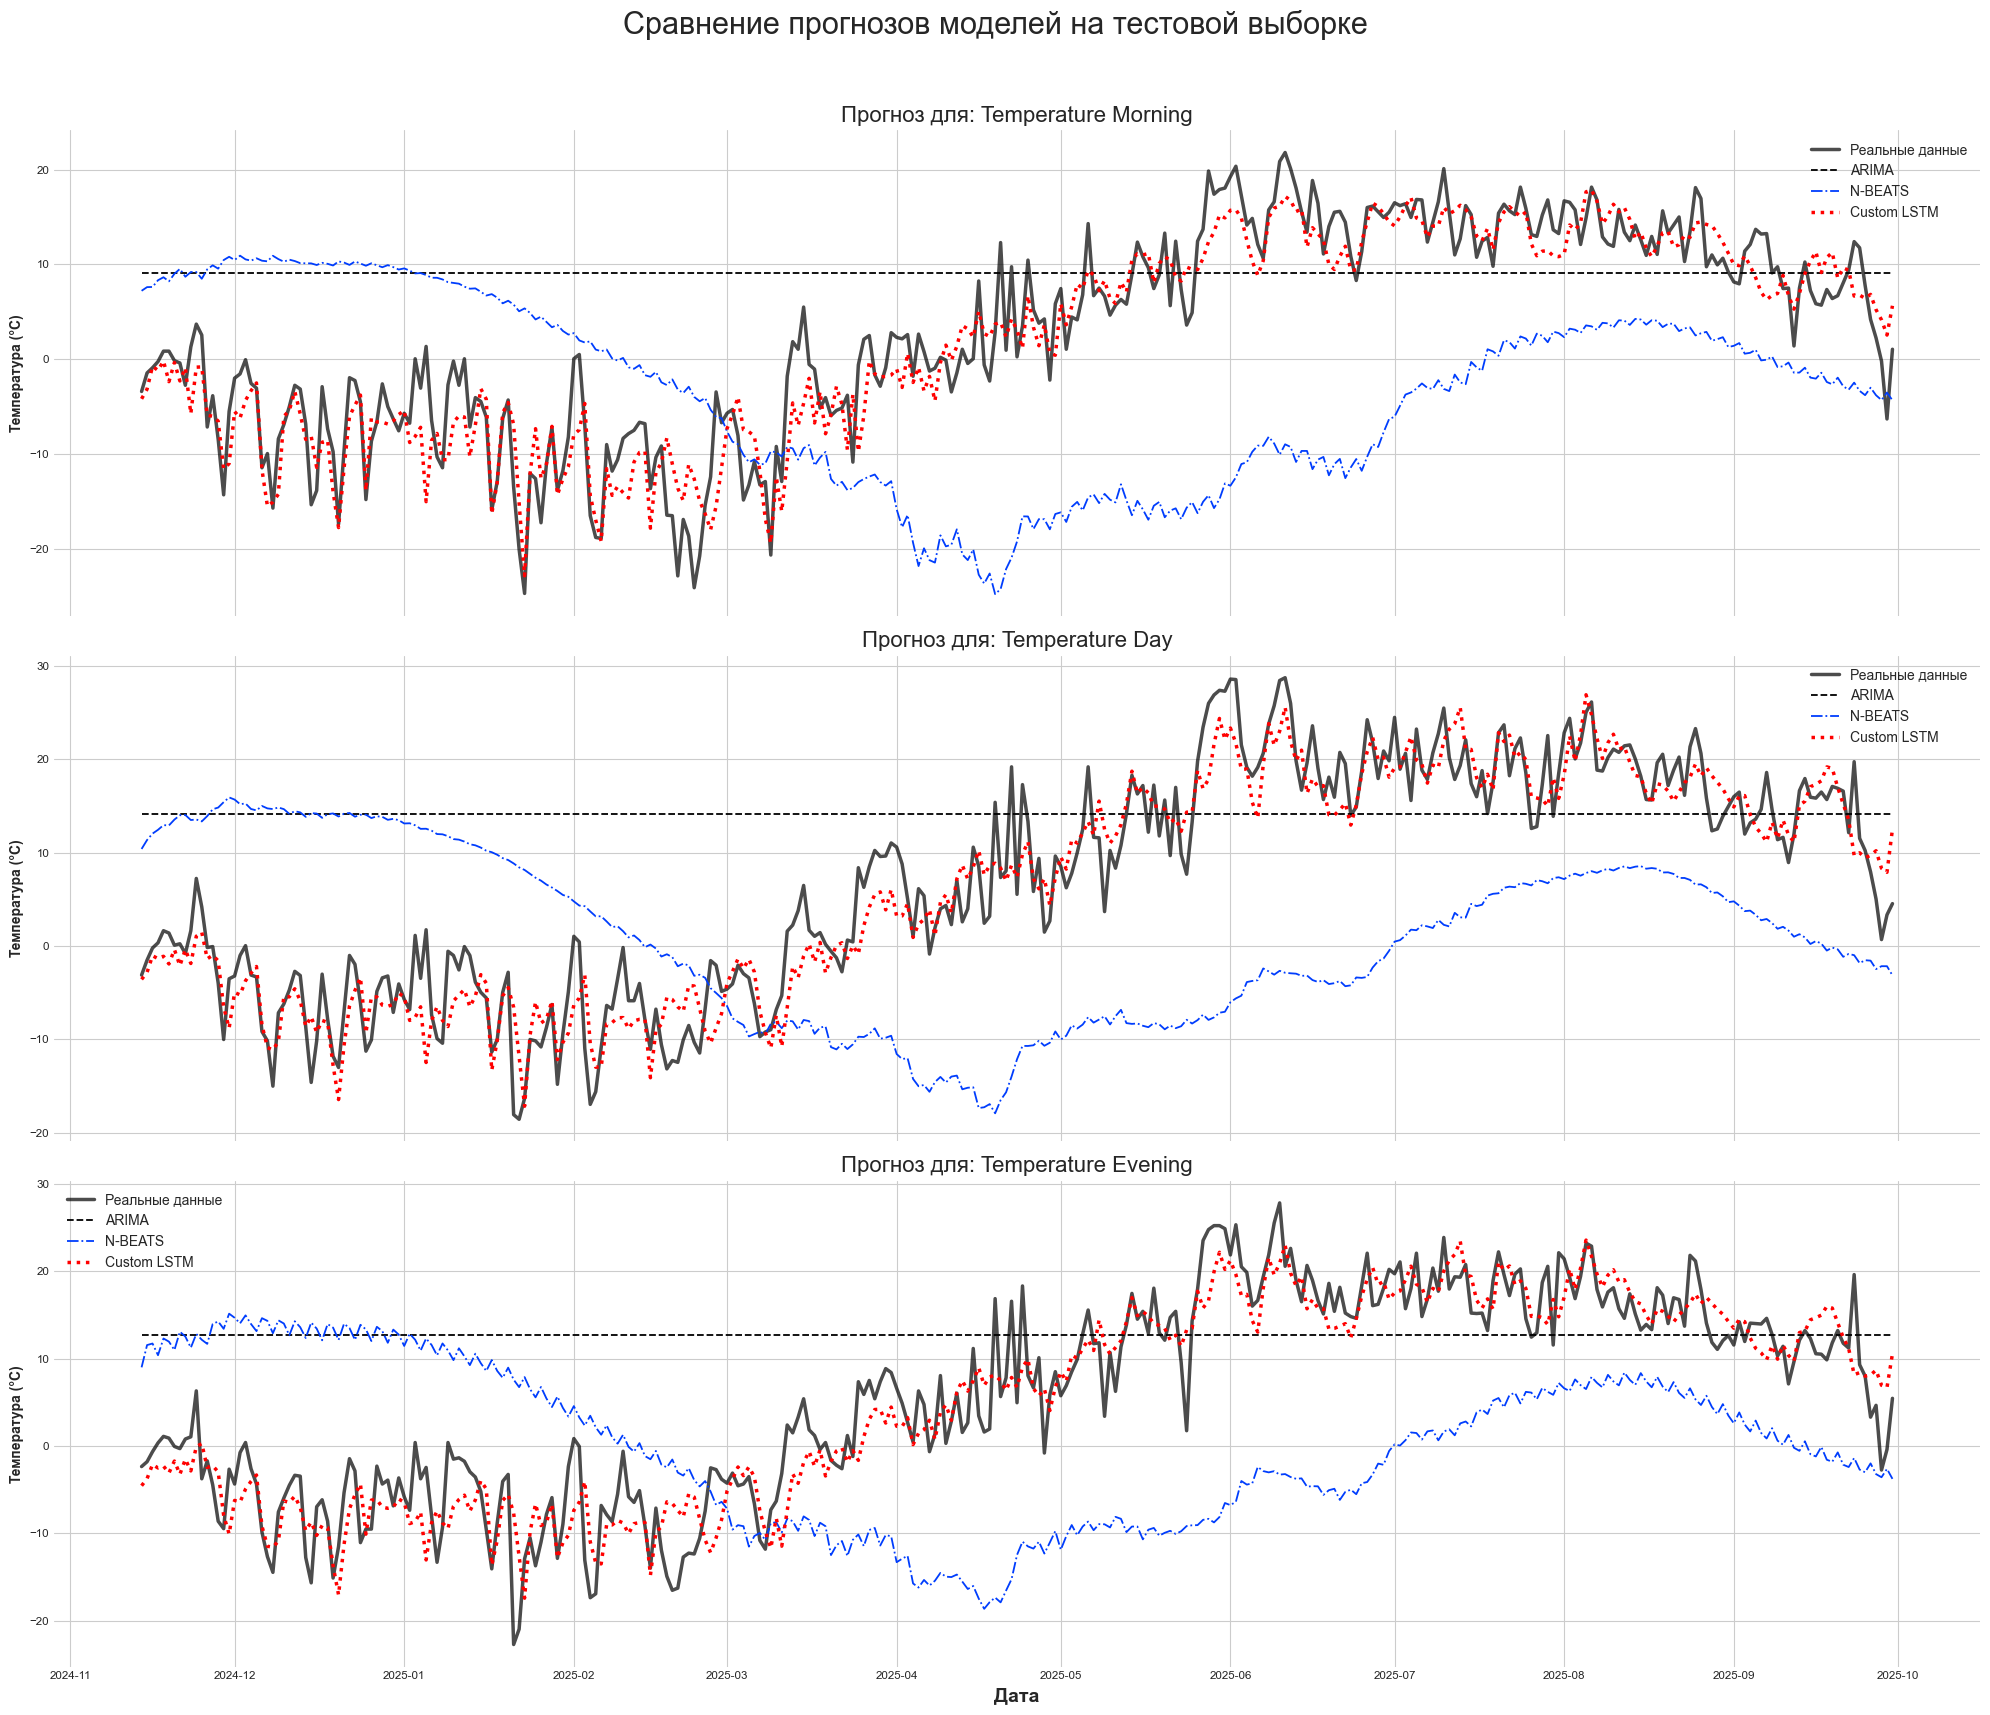



--- Итоговая таблица метрик ---


In [26]:
y_test_actual = df_test[TARGET_COLS].values[SEQ_LENGTH:]
test_dates = df_test.index[SEQ_LENGTH:]


arima_preds_short = arima_preds[:len(y_test_actual)]
nbeats_preds_short = nbeats_preds[:len(y_test_actual)]

ts_actual = TimeSeries.from_times_and_values(test_dates, y_test_actual)


ts_arima = TimeSeries.from_times_and_values(test_dates, arima_preds_short)
ts_nbeats = TimeSeries.from_times_and_values(test_dates, nbeats_preds_short)
ts_lstm = TimeSeries.from_times_and_values(test_dates, lstm_preds)


metrics = {}
for i, target_name in enumerate(TARGET_COLS):
    
    actual_component = ts_actual.univariate_component(i)
    
    metrics[target_name] = {
        'ARIMA': {'MAE': mae(actual_component, ts_arima.univariate_component(i)), 
                  'MAPE (%)': mape(actual_component, ts_arima.univariate_component(i))},
        'N-BEATS': {'MAE': mae(actual_component, ts_nbeats.univariate_component(i)), 
                    'MAPE (%)': mape(actual_component, ts_nbeats.univariate_component(i))},
        'Custom LSTM': {'MAE': mae(actual_component, ts_lstm.univariate_component(i)), 
                        'MAPE (%)': mape(actual_component, ts_lstm.univariate_component(i))}
    }


fig, axes = plt.subplots(3, 1, figsize=(20, 18), sharex=True)
fig.suptitle('Сравнение прогнозов моделей на тестовой выборке', fontsize=22)

for i, target_name in enumerate(TARGET_COLS):
    axes[i].plot(test_dates, y_test_actual[:, i], label='Реальные данные', color='black', linewidth=2.5, alpha=0.7)
    axes[i].plot(test_dates, arima_preds_short[:, i], label='ARIMA', linestyle='--')
    axes[i].plot(test_dates, nbeats_preds_short[:, i], label='N-BEATS', linestyle='-.')
    axes[i].plot(test_dates, lstm_preds[:, i], label='Custom LSTM', linestyle=':', color='red', linewidth=2.5)
    axes[i].set_title(f'Прогноз для: {target_name.replace("_", " ").title()}', fontsize=16)
    axes[i].legend()
    axes[i].set_ylabel("Температура (°C)")

plt.xlabel('Дата', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


results_df = pd.DataFrame.from_dict({(i,j): metrics[i][j] for i in metrics.keys() for j in metrics[i].keys()}, orient='index')

print("\n\n--- Итоговая таблица метрик ---")
display(results_df.style.background_gradient(cmap='viridis_r', subset=['MAE', 'MAPE (%)']))